In [4]:
import torch
from model import make_model
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from utils import greedy_decode

I0910 17:26:13.215046 140734749527488 file_utils.py:39] PyTorch version 1.6.0 available.


In [1]:
num_decoder_layers = 3
model_path = './chatbot-ckpt/step_130000.pth'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, vocab = make_model(num_decoder_layers)
model.load_state_dict(torch.load(model_path, map_location=device)['model'])
model.eval()
sp  = SentencepieceTokenizer(get_tokenizer())

I0910 17:26:31.371706 140734749527488 configuration_utils.py:300] Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 8002
}

using cached model
using cached model
using cached model


In [45]:
question = '사랑해요.'
max_len = 20

tokens = sp(question)
tokens = ['[CLS]'] + tokens + ['[SEP]']
token_ids = [vocab.token_to_idx[tok] for tok in tokens]
# unsqueeze(0) for Batch position (zzingae)
token_ids = torch.tensor(token_ids).unsqueeze(0)
# attention score: [Batch, Head, tgt_length, src_length] in src_attn (zzingae)
# unsqueeze(1) for tgt_length position (zzingae)
attn_mask = (token_ids != vocab.token_to_idx['[PAD]']).unsqueeze(1).long()

answer = greedy_decode(model, token_ids, attn_mask, max_len, vocab)

with open('QnA_examples.txt','a',encoding='utf-8') as txt:
    Q = 'question: {}'.format(sp(question))
    A = 'answer: '+''.join([vocab.idx_to_token[idx] for idx in answer[0,1:]])
    txt.write(Q+'\n'+A+'\n')
    print(Q)
    print(A)

question: ['▁사랑', '해', '요', '.']
answer: ▁솔직하게▁대화해보세요.


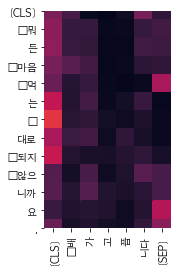

In [43]:
import matplotlib.pylab as plt
import seaborn

# for showing Korean in plot
plt.rcParams['font.family'] = 'AppleGothic'

def draw(data, x, y):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

last_layer = 2
Q = tokens
A = [vocab.idx_to_token[idx] for idx in answer[0,:]]
# mean of attention weights from all heads (zzingae)
mean_enc_dec_attention_weight = torch.mean(model.decoder.layers[last_layer].src_attn.attn.data,dim=[0,1])

plt.figure()
draw(mean_enc_dec_attention_weight, Q, A)
plt.show()

In [33]:
question

['[CLS]', '▁사랑', '[SEP]']

In [34]:
answer = [vocab.idx_to_token[idx] for idx in answer[0,:]]

TypeError: list indices must be integers or slices, not tuple